In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import mysql.connector
import numpy as np

Connection to database and created an instance

In [2]:
db = mysql.connector.connect(
    host="localhost", user="root", password="Tanmay@2001", database="target_ecommerce"
)

cursor = db.cursor()

List all unique cities where customers are located.

In [3]:
query1 = "SELECT DISTINCT(customer_city) from customers"
cursor.execute(query1)
data = cursor.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


Count the number of orders placed in 2017.

In [18]:
query2 = "SELECT COUNT(order_id) FROM orders WHERE year(order_purchase_timestamp) = 2017"
cursor.execute(query2)
data = cursor.fetchall()
print("total orders placed in 2017 are", data[0][0])

total orders placed in 2017 are 45101


Find the total sales per category.

In [19]:
query3 = """SELECT products.product_category,ROUND(SUM(payments.payment_value),2)
FROM products JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY product_category
"""
cursor.execute(query3)
data = cursor.fetchall()
df = pd.DataFrame(data,columns=["Category","Sales"])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


Calculate the percentage of orders that were paid in installments.

In [21]:
query4 = """SELECT (SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END))/COUNT(*)*100
FROM payments"""
cursor.execute(query4)
data = cursor.fetchall()
print("the percentage of orders that were paid in installments is",data)

the percentage of orders that were paid in installments is [(Decimal('99.9981'),)]


Count the number of customers from each state.

   State  Customer_count
0     SP           41746
4     RJ           12852
2     MG           11635
5     RS            5466
3     PR            5045
1     SC            3637
9     BA            3380
13    DF            2140
8     ES            2033
7     GO            2020
15    PE            1652
12    CE            1336
6     PA             975
16    MT             907
10    MA             747
11    MS             715
21    PB             536
23    PI             495
14    RN             485
19    AL             413
25    SE             350
22    TO             280
20    RO             253
17    AM             148
24    AC              81
18    AP              68
26    RR              46


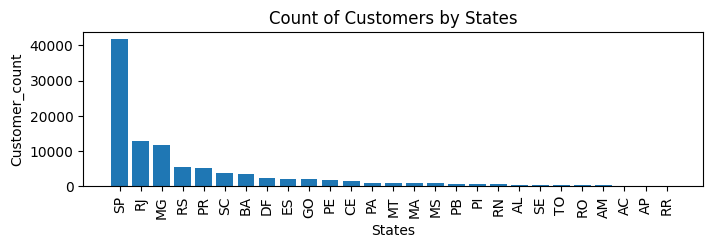

In [7]:
query5 = """SELECT customer_state, COUNT(customer_id) FROM customers GROUP BY customer_state"""
cursor.execute(query5)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["State", "Customer_count"]).sort_values(
    by="Customer_count", ascending=False
)
print(df)
plt.figure(figsize=(8, 2))
plt.bar(df["State"], df["Customer_count"])
plt.xlabel("States")
plt.ylabel("Customer_count")
plt.title("Count of Customers by States")
plt.xticks(rotation=90)
plt.show()

Calculate the number of orders per month in 2018.

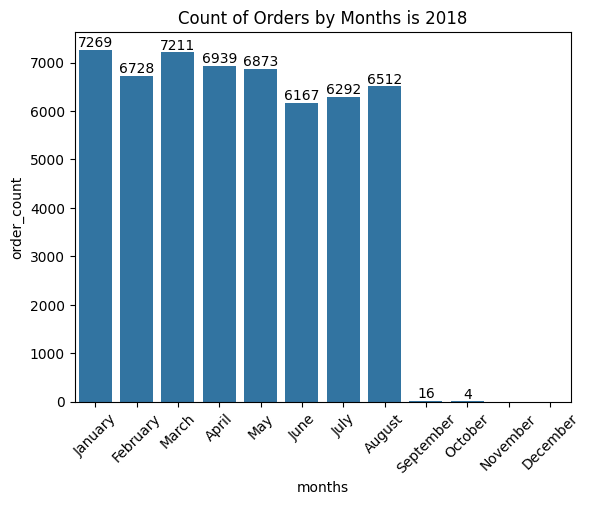

In [8]:
query6 = """SELECT MONTHNAME(order_purchase_timestamp) months, COUNT(order_id) order_count FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018 GROUP BY months"""
cursor.execute(query6)
data = cursor.fetchall()
df = pd.DataFrame(data,columns=["months","order_count"])
o = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax = sb.barplot(x = df["months"], y = df["order_count"],data = df,order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")
plt.show()

Find the average number of products per order, grouped by customer city.

In [9]:
query7 = """with count_per_order as (
SELECT orders.order_id, orders.customer_id,
COUNT(order_items.order_id) as oc from orders
join order_items on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id
)
select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from customers
join count_per_order on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders
"""
cursor.execute(query7)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["customer_city","average_products/order"])
df.head(10)

,customer_city,average_products/order
0,sonora,1.00
1,porteiras,1.00
2,itabi,1.00
3,silvanopolis,1.00
4,salmourao,1.00
5,cha de alegria,1.00
6,cerro grande,1.00
7,francisco santos,1.00
8,barras,1.00
9,grupiara,1.00


Calculate the percentage of total revenue contributed by each product category.

In [10]:
query8 = """select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items on products.product_id = order_items.product_id
join payments on payments.order_id = order_items.order_id group by category order by sales desc
"""
cursor.execute(query8)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["category","'%' distribution"])
print(df.head())

               category  '%' distribution
0        BED TABLE BATH             10.70
1         HEALTH BEAUTY             10.35
2  COMPUTER ACCESSORIES              9.90
3  FURNITURE DECORATION              8.93
4       WATCHES PRESENT              8.93


Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
query9 = """select products.product_category, count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items on products.product_id = order_items.product_id
group by products.product_category
"""
cursor.execute(query9)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["category", "order_count", "price"])
print(df.head())
arr1 = df["order_count"]
arr2 = df["price"]
result = np.corrcoef([arr1, arr2])
print(result)

               category  order_count   price
0         HEALTH BEAUTY         9670  130.16
1         sport leisure         8641  114.34
2            Cool Stuff         3796  167.36
3  computer accessories         7827  116.51
4       Watches present         5991  201.14
[[ 1.         -0.10631514]
 [-0.10631514  1.        ]]


Calculate the total revenue generated by each seller, and rank them by revenue.

                          seller_id        revenue  rank
0  7c67e1448b00f6e969d365cea6b010ab  507166.907302     1
1  1025f0e2d44d7041d6cf58b6550e0bfa  308222.039840     2
2  4a3ca9315b744ce9f8e9374361493884  301245.269765     3
3  1f50f920176fa81dab994f9023523100  290253.420128     4
4  53243585a1d6dc2643021fd1853d8905  284903.080498     5


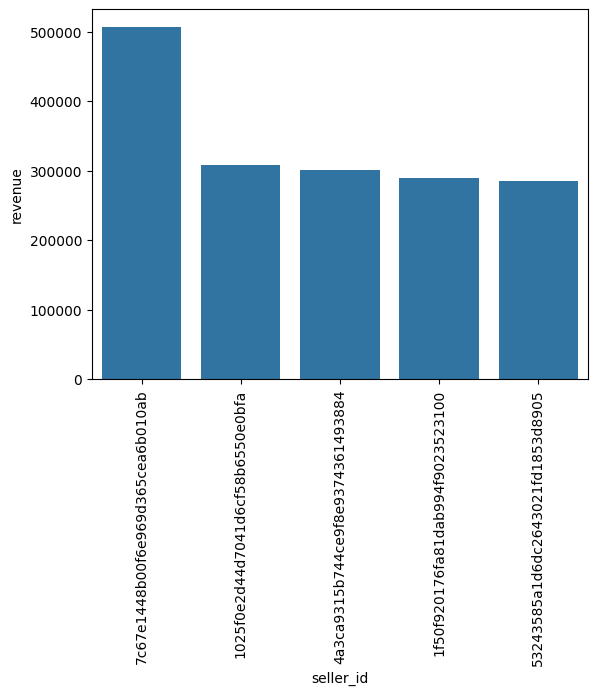

In [12]:
query10 = """SELECT *, dense_rank() over(order by revenue desc) as rn
from(SELECT order_items.seller_id,sum(payments.payment_value) revenue
from order_items join payments on
order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""
cursor.execute(query10)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["seller_id", "revenue", "rank"])
print(df.head())
sb.barplot(x="seller_id", y="revenue", data=df.head())
plt.xticks(rotation = 90)
plt.show()

Calculate the moving average of order values for each customer over their order history.

In [13]:
query11 = """
select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from (select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment from payments join orders
on payments.order_id = orders.order_id) as a"""
cursor.execute(query11)
data = cursor.fetchall()
df = pd.DataFrame(data)
print(df)

                                       0                    1       2  \
0       00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.74   
1       000161a058600d5901f007fab4c27140  2017-07-16 09:40:32   67.41   
2       0001fd6190edaaf884bcaf3d49edf079  2017-02-28 11:06:43  195.42   
3       0002414f95344307404f0ace7a26f1d5  2017-08-16 13:09:20  179.35   
4       000379cdec625522490c315e70c7a9fb  2018-04-02 13:42:17  107.01   
...                                  ...                  ...     ...   
103881  fffecc9f79fd8c764f843e9951b11341  2018-03-29 16:59:26    0.64   
103882  fffeda5b6d849fbd39689bb92087f431  2018-05-22 13:36:02   63.13   
103883  ffff42319e9b2d713724ae527742af25  2018-06-13 16:57:05  214.13   
103884  ffffa3172527f765de70084a7e53aae8  2017-09-02 11:53:32   45.50   
103885  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03   18.37   

                 3  
0       114.739998  
1        67.410004  
2       195.419998  
3       179.350006  
4       107.010002

Calculate the cumulative sales per month for each year.

In [14]:
query12 = """select years,months,payment,sum(payment) over(order by years, months) cumulative_sales
            from
            (select year(orders.order_purchase_timestamp) as years,
            month(orders.order_purchase_timestamp) as months,
            round(sum(payments.payment_value),2) as payment from orders join payments
            on orders.order_id = payments.order_id
            group by years, months order by years,months) as a"""
cursor.execute(query12)
data = cursor.fetchall()
df = pd.DataFrame(data,columns=["year","month","sales","cumulative sales"])
print(df)

    year  month       sales  cumulative sales
0   2016      9      252.24            252.24
1   2016     10    59090.48          59342.72
2   2016     12       19.62          59362.34
3   2017      1   138488.04         197850.38
4   2017      2   291908.01         489758.39
5   2017      3   449863.60         939621.99
6   2017      4   417788.03        1357410.02
7   2017      5   592918.82        1950328.84
8   2017      6   511276.38        2461605.22
9   2017      7   592382.92        3053988.14
10  2017      8   674396.32        3728384.46
11  2017      9   727762.45        4456146.91
12  2017     10   779677.88        5235824.79
13  2017     11  1194882.80        6430707.59
14  2017     12   878401.48        7309109.07
15  2018      1  1115004.18        8424113.25
16  2018      2   992463.34        9416576.59
17  2018      3  1159652.12       10576228.71
18  2018      4  1160785.48       11737014.19
19  2018      5  1153982.15       12890996.34
20  2018      6  1023880.50       

Calculate the year-over-year growth rate of total sales.

In [15]:
query13 = """with a as
            (select year(orders.order_purchase_timestamp) as years,
            round(sum(payments.payment_value),2) as payment from orders join payments
            on orders.order_id = payments.order_id
            group by years order by years)
            
            select years, ((payment - lag(payment,1) over(order by years)) /
            lag(payment,1) over(order by years)) * 100 from a"""
cursor.execute(query13)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["years", "yoy % growth"])
print(df)

   years  yoy % growth
0   2016           NaN
1   2017  12112.703761
2   2018     20.000924


Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [16]:
query14 = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),
b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""
cursor.execute(query14)
data = cursor.fetchall()
print(data)

[(None,)]


Identify the top 3 customers who spent the most money in each year.

   years                                id       payment  rank
0   2016  a9dc96b027d1252bbac0a9b72d837fc6   1423.550049     1
1   2016  1d34ed25963d5aae4cf3d7f3a4cda173   1400.739990     2
2   2016  4a06381959b6670756de02e07b83815f   1227.780029     3
3   2017  1617b1357756262bfa56ab541c47bc16  13664.080078     1
4   2017  c6e2731c5b391845f6800c97401a43a9   6929.310059     2
5   2017  3fd6777bbce08a352fddd04e4a7cc8f6   6726.660156     3
6   2018  ec5b2ba62e574342386871631fafd3fc   7274.879883     1
7   2018  f48d464a0baaea338cb25f816991ab1f   6922.209961     2
8   2018  e0a2412720e9ea4f26c1ac985f6a7358   4809.439941     3


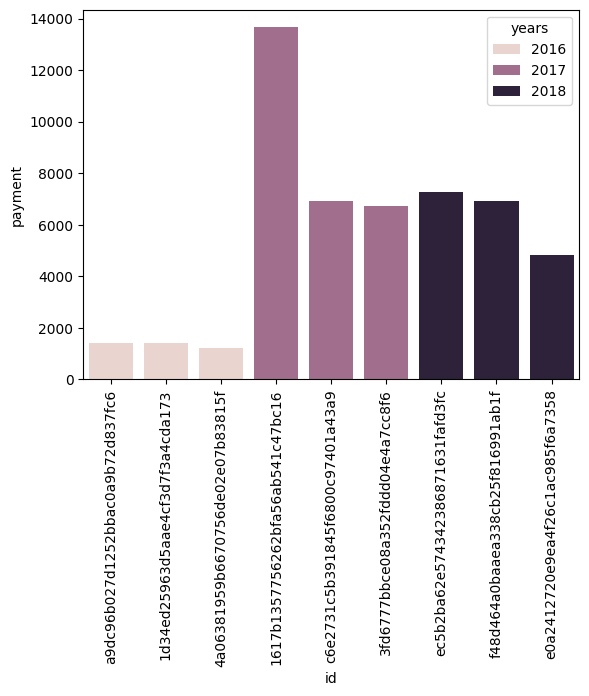

In [17]:
query15 = """
        select years, customer_id, payment, d_rank 
        from
        (select year(orders.order_purchase_timestamp) years, orders.customer_id,
        sum(payments.payment_value) payment,
        dense_rank() over(partition by year(orders.order_purchase_timestamp)
        order by sum(payments.payment_value) desc) d_rank
        from orders join payments
        on payments.order_id = orders.order_id
        group by year(orders.order_purchase_timestamp),
        orders.customer_id) as a
        where d_rank <=3"""
cursor.execute(query15)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["years", "id", "payment", "rank"])
print(df)
sb.barplot(x="id", y="payment", data=df, hue="years")
plt.xticks(rotation=90)
plt.show()